In [1]:
! nvidia-smi # bash command to controll the status of GPUs

Fri Nov 11 12:51:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:03:00.0 Off |                  N/A |
| 35%   63C    P2   179W / 350W |  12296MiB / 24576MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:04:00.0 Off |                  N/A |
| 32%   

In [2]:
import os, random

cuda_device = 5 # which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"] = str(cuda_device) # set which GPU device are visible

In [3]:
# "Basic" py library
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split 
from nltk.tokenize import word_tokenize

# Stats 
from mlxtend.evaluate import permutation_test

# visualisation
from matplotlib import pyplot as plt # basic visualisation in py
import seaborn as sns # great to interact with dataframes
import plotly.express as px # powerfull for interactive figures
from tqdm import tqdm  # generats progress bar to controll steps

# ML py
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch # Pytorch, Meta's library for ML
import torch.nn as nn # Pt module for neural networks 

import transformers # HuggingFace library to use pretrained models
from transformers import BertTokenizer, BertModel

In [4]:
def set_seed(seed: int):
    """Helper function for reproducible behavior to set the seed in ``random``, 
        ``numpy``, ``torch`` and/or ``tf`` (if installed).

    Args:
        seed (:obj:`int`): The seed to set.
    """
    from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
    
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
    if is_tf_available():
        import tensorflow as tf

        tf.random.set_seed(seed)


def cutted_countplot(data, X, palette, top, bottom, x_lbl, y_lbl):
    """Visualisation function, draws a "cutted" barplot for those cases where one 
        or more outliers make the visualisation complicated

    Args:
        data: df, the data to visulise 
        X, Y: string, the the name of x and y axis 
        palette: color set
        top, bottom: integer, where to interrupt and reptart the plot (on y axe)
        x_lbl, y_lbl: string, names of the labels for the axes
    """
    f, (ax_top, ax_bottom) = plt.subplots(
        ncols=1, 
        nrows=2, 
        sharex=True, 
        gridspec_kw={'hspace':0.05},
        figsize=(20,8),
    )

    g1 = sns.countplot(
        data=data,
        x=X,
        palette=palette,
        ax=ax_top
    )
    g1.set_xlabel(""), g1.set_ylabel("")

    g2 = sns.countplot(
        data=data,
        x=X,
        palette=palette,
        ax=ax_bottom
    )
    g2.set_xlabel(""), g2.set_ylabel("")

    ax_top.set_ylim(bottom=top)   # those limits are fake
    ax_bottom.set_ylim(0,bottom)

    sns.despine(ax=ax_bottom)
    sns.despine(ax=ax_top, bottom=True)

    ax = ax_top
    d = .005  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal

    ax2 = ax_bottom
    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal

    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
    )

    f.text(0.5, -.1, x_lbl, ha='center')
    f.text(.07, 0.5, y_lbl, va='center', rotation='vertical')
    plt.show()

In [5]:
# Set visual style of Seabonr
sns.set("talk")
sns.set_style("whitegrid")

#  set the random seed 
seed = 31
set_seed(seed)

# Table of Content

click on the titles to reach the described sections

---------
[Loading Data](#intro)

[Distributions Visualisation](#visualisation)
 
[Clustering](#clstr)

## Loading data<a id='intro'></a>

In [6]:
dream_records = pd.read_csv(
    "Reports_with_Dreamer_and_General_Emotions_PCAxy_tSNExy.csv",
)

dream_records.sample(3)

,gender,age,type,collection,id,time,date,number,report,# words,All Emotions,Dreamer Emotions,# Dreamer Emotions,# General Emotions,TSNE_x,TSNE_y,PCA_x,PCA_y
1506,M,Y,set,Hall/VdC Norms: Male,norms-m,1940s-1950s,Missing,0157,I walked out of the washroom at our country cl...,92,AP_SD,AP_SD,2,2,25.522667,13.963650,-2.104239,-1.645520
933,F,Y,set,Hall/VdC Norms: Female,norms-f,1940s-1950s,Missing,0070,I had to take an exam in the psych lab. When I...,161,Missing,Missing,0,0,4.794139,20.368893,-0.621066,-1.351107
1820,M,Y,set,Hall/VdC Norms: Male,norms-m,1940s-1950s,Missing,0476,In this dream I received a letter from my girl...,136,AN_SD,AN_SD,2,2,1.004393,1.110627,1.457004,-1.260987


In [7]:
# Load the dataset in CSV (already has BERT–Large emb. and PCA/t-SNE coordinates)
encodings_in_DF = False
with open('BERT-Large-Cased_dream_records.npy', 'rb') as f:
    T_encoding = np.load(f)
    
# del T_encoding 
if encodings_in_DF:
    dream_records["BERT-large-case-embeddings"] = list(T_encoding)

In [8]:
len(dream_records[dream_records["# words"] == 0])

0

## Distributions Visualisation<a id='visualisation'></a>
###### Commection distribution

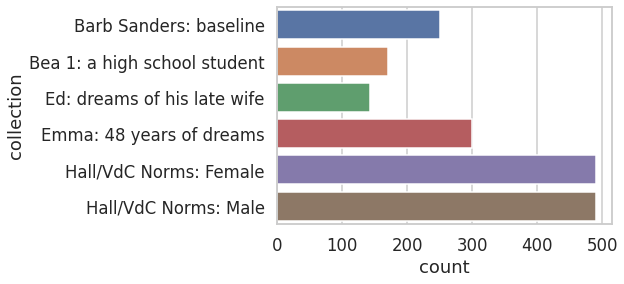

In [9]:
g = sns.countplot(
    data=dream_records, y="collection",
)

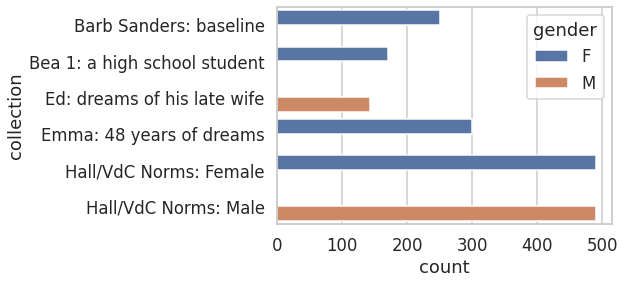

In [10]:
g = sns.countplot(
    data=dream_records, y="collection",
    hue="gender"
)

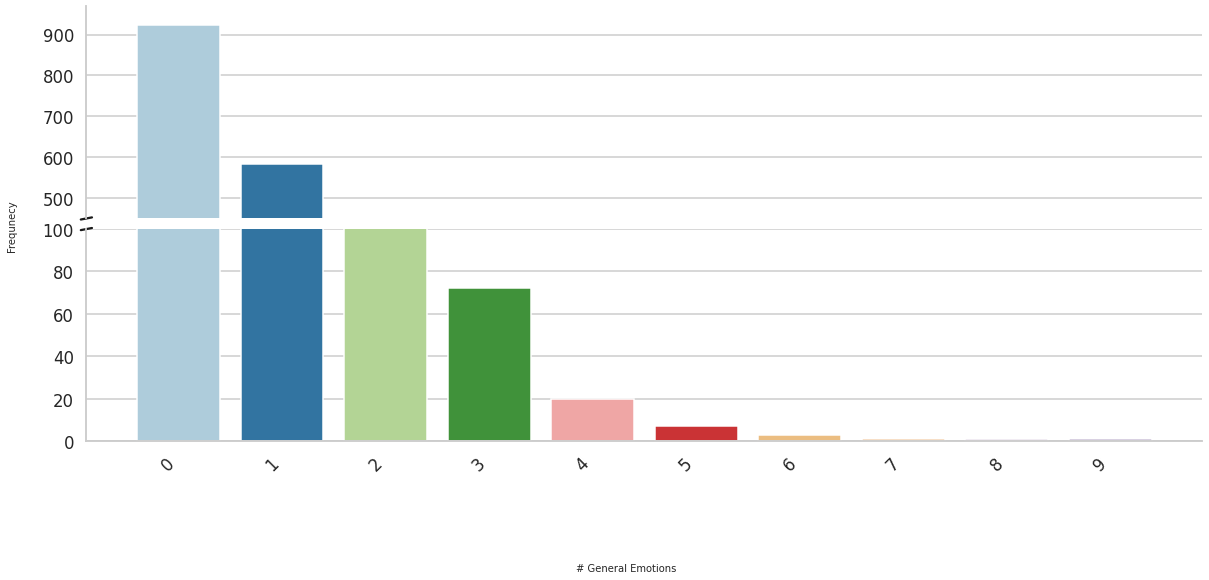

In [11]:
cutted_countplot(
dream_records, 
"# General Emotions",
"Paired", 
450, 
100, 
"# General Emotions",
"Frequnecy"
)

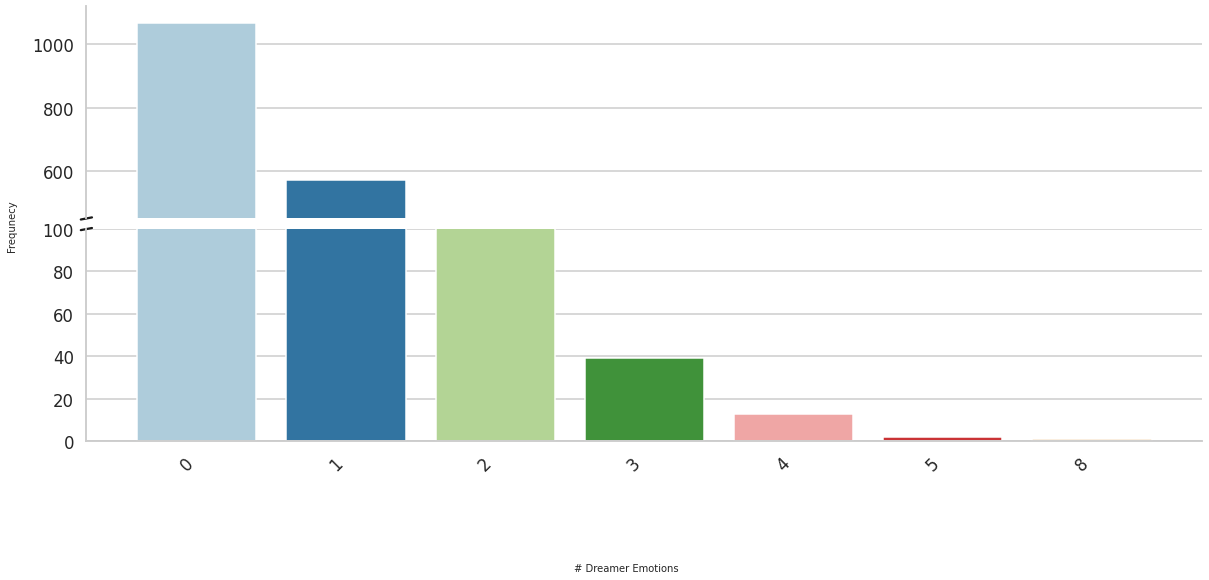

In [12]:
cutted_countplot(
dream_records, 
"# Dreamer Emotions",
"Paired", 
450, 
100, 
"# Dreamer Emotions",
"Frequnecy"
)

###### Collection

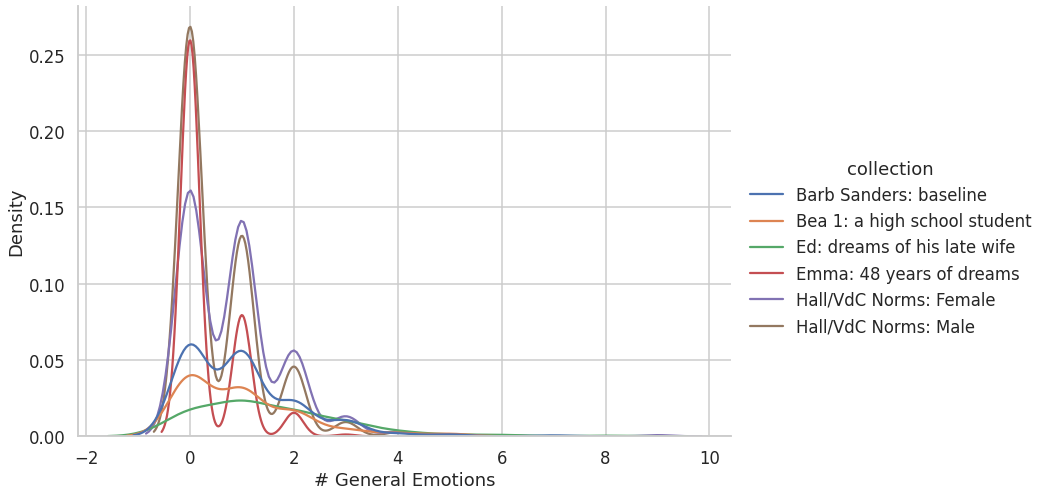

In [13]:
g = sns.displot(
    data=dream_records, 
    x="# General Emotions",
    hue="collection",
    height=7,
    aspect=1.5, 
    kind="kde",
)

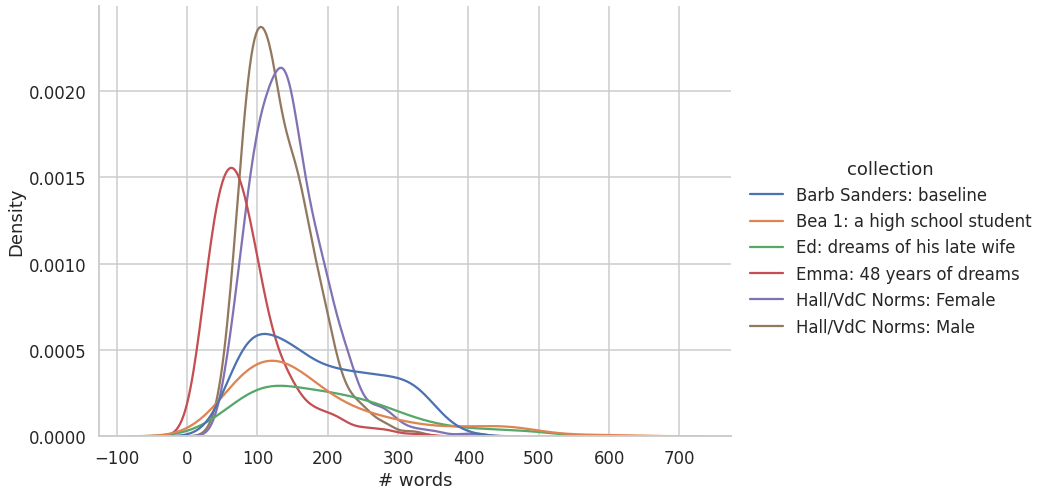

In [14]:
g = sns.displot(
    data=dream_records, 
    x="# words",
    hue="collection",
    height=7,
    aspect=1.5, 
    kind="kde",
)

###### Gender

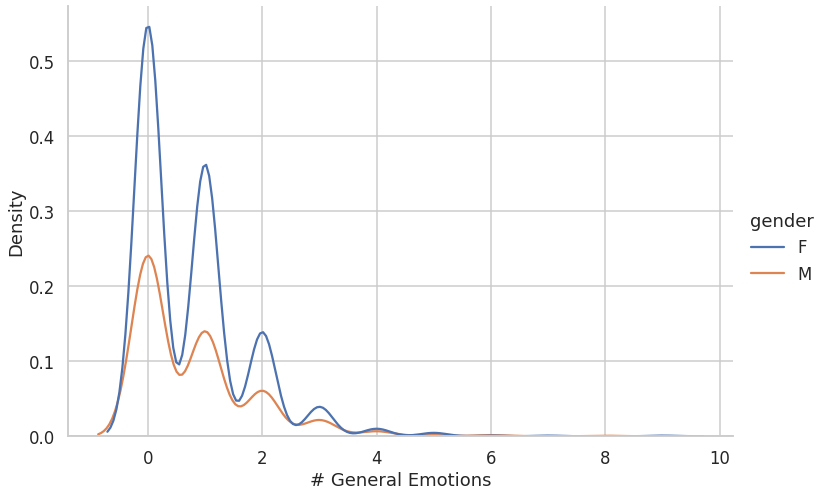

In [15]:
g = sns.displot(
    data=dream_records, 
    x="# General Emotions",
    hue="gender",
    height=7,
    aspect=1.5, 
    kind="kde",
)

In [16]:
M_nLbls = dream_records[dream_records["gender"].isin(['M'])]["# General Emotions"]
F_nLbls = dream_records[dream_records["gender"].isin(['F'])]["# General Emotions"]

p_value = permutation_test(
                M_nLbls, F_nLbls,
                method='approximate',
                num_rounds=100000,
                seed=seed,
                paired=False
)
                           
print("Permutation Test, # lables M vs F: pval {:.6f}".format(p_value))

Permutation Test, # lables M vs F: pval 0.526515


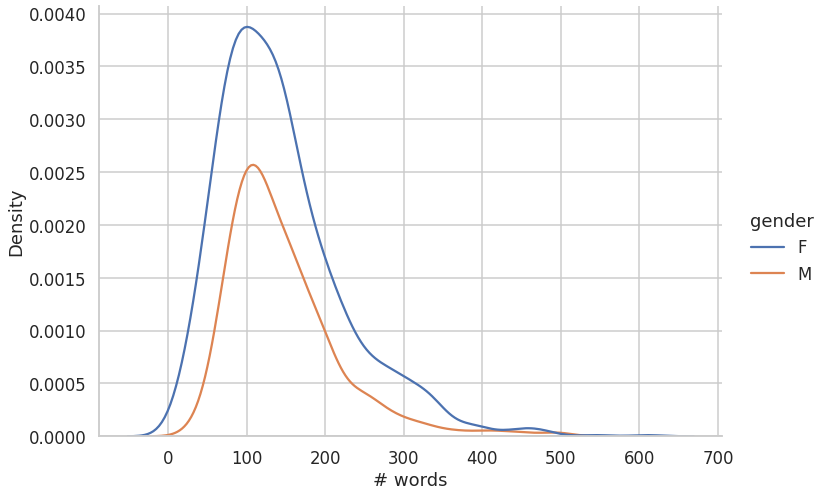

In [17]:
g = sns.displot(
    data=dream_records, 
    x="# words",
    hue="gender",
    height=7,
    aspect=1.5, 
    kind="kde",
)

In [18]:
M_nWrd = dream_records[dream_records["gender"].isin(['M'])]["# words"]
F_nWrd = dream_records[dream_records["gender"].isin(['F'])]["# words"]

p_value = permutation_test(
                M_nWrd, F_nWrd,
                method='approximate',
                num_rounds=100000,
                seed=seed, 
                paired=False
)
print("Permutation Test, # words M vs F: pval {:.6f}".format(p_value))

Permutation Test, # words M vs F: pval 0.457665


###### Time Window

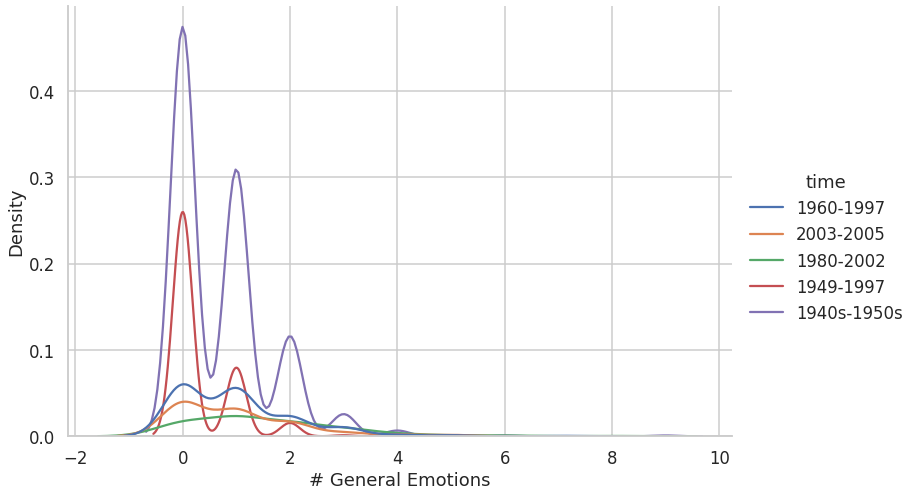

In [19]:
g = sns.displot(
    data=dream_records, 
    x="# General Emotions",
    hue="time",
    height=7,
    aspect=1.5, 
    kind="kde",
)

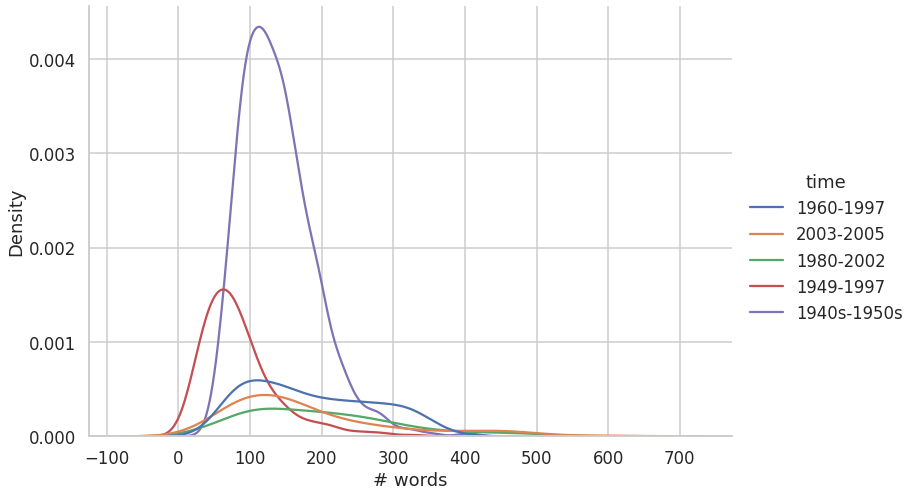

In [20]:
# # Looks like is not age...
g = sns.displot(
    data=dream_records, 
    x="# words",
    hue="time",
    height=7,
    aspect=1.5, 
    kind="kde",
)

###### Correlation # words – # Emotions

In [21]:
rho, p = spearmanr(dream_records["# words"], dream_records["# General Emotions"])
print("Sperman's correlation {} - {}\n\u03C1:{:.2f}  pval:{:.5f}".format(
                                                            "# words","# labels", rho, p
                                                        )
)

Sperman's correlation # words - # labels
ρ:0.34  pval:0.00000


<Figure size 720x720 with 0 Axes>

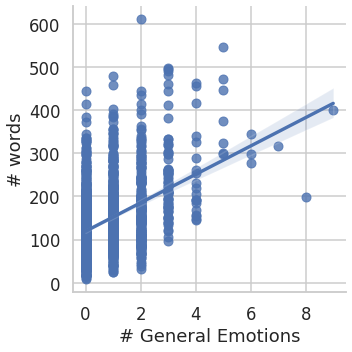

In [22]:
fig = plt.figure(figsize=(10,10))
g = sns.lmplot(
    data=dream_records, 
    y="# words", 
    x="# General Emotions",
)

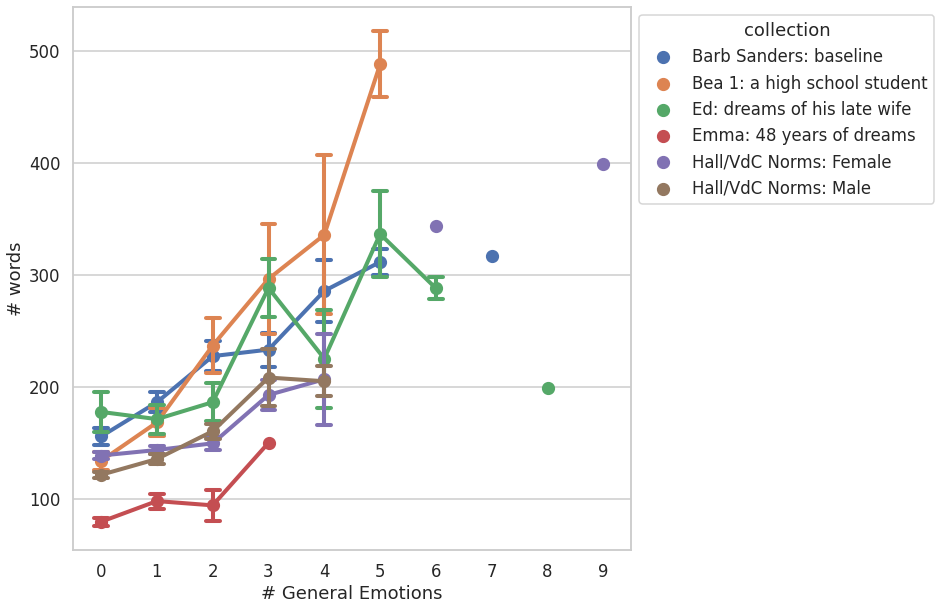

In [23]:
fig = plt.figure(figsize=(10,10))
g = sns.pointplot(
    data=dream_records, 
    y="# words", 
    x="# General Emotions",
    hue="collection",
    errorbar=('se', 1),
    capsize=.25,
)

sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

In [24]:
word_to_emotion = []
for n_wrds, n_emt, Ems in dream_records[["# words", "# General Emotions", "All Emotions"]].values:
    for em in Ems.split("_"):
        word_to_emotion.append([n_wrds, n_emt, em])
        
word_to_emotion_df = pd.DataFrame(word_to_emotion, columns=["# Words", "# General Emotions", "All Emotion"])

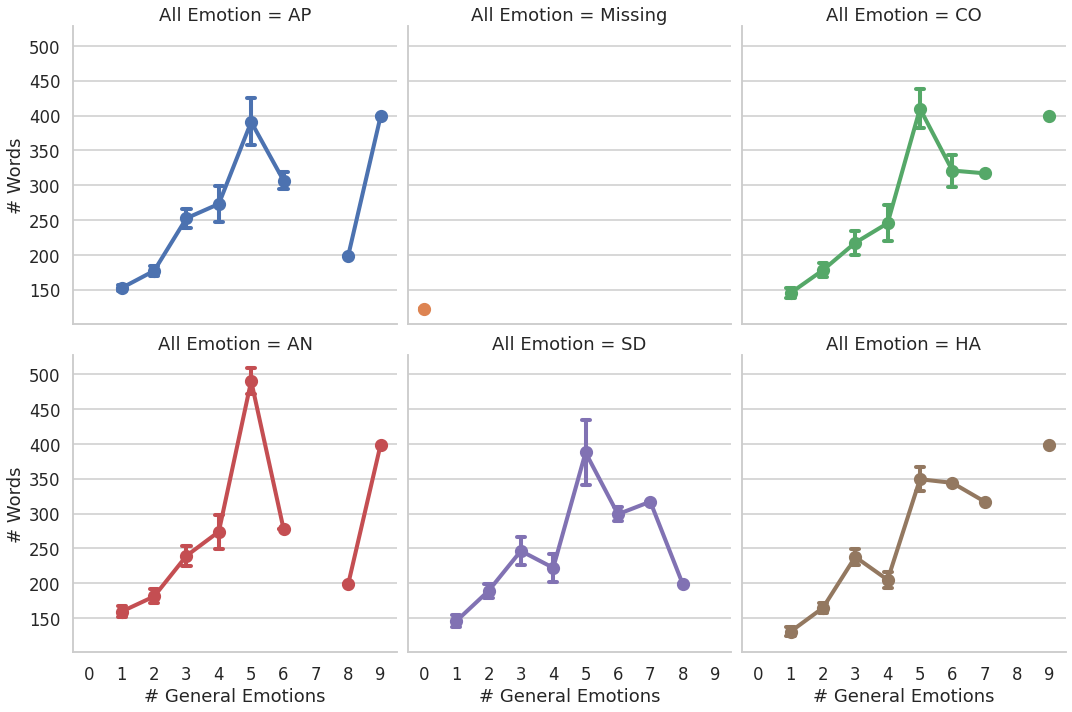

In [25]:
# fig = plt.figure(figsize=(10,10))
g = sns.catplot(
    data=word_to_emotion_df, 
    y="# Words", 
    x="# General Emotions",
    hue="All Emotion",
    errorbar=('se', 1),
    capsize=.25,
    kind="point",
    col="All Emotion",
    join=True,
    col_wrap=3,
)

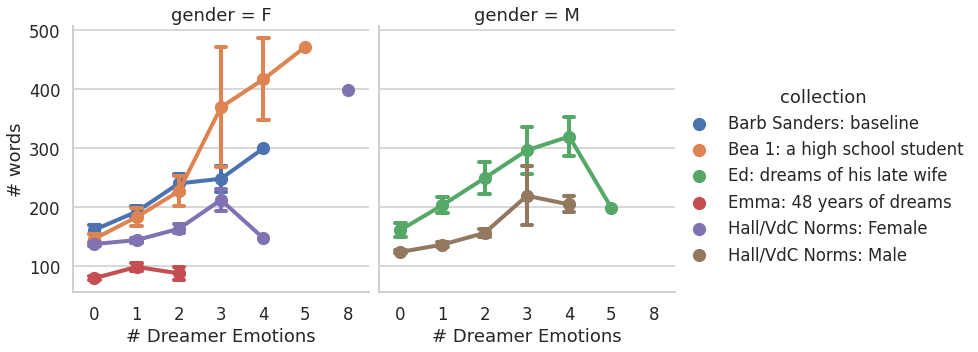

In [26]:
g = sns.catplot(
    data=dream_records, 
    y="# words", 
    x="# Dreamer Emotions",
    hue="collection",
    errorbar=('se', 1),
    capsize=.25,
    kind="point",
    col="gender",
    join=True,
)

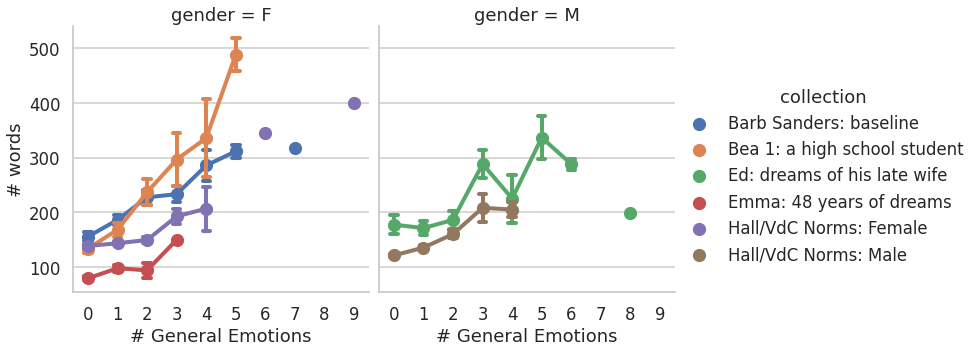

In [27]:
# fig = plt.figure(figsize=(10,10))
g = sns.catplot(
    data=dream_records, 
    y="# words", 
    x="# General Emotions",
    hue="collection",
    errorbar=('se', 1),
    capsize=.25,
    kind="point",
    col="gender",
    join=True,
)

Number (\#) of Emotions and words seems to grow almost linearly untill a certain point.

## Report Encoding's Analysis <a id='encoding'></a>

### Clustering<a id='clstr'></a>
Q1: can we visually cluseter embeddings of dreams based on things as comunity \[sane vs. ill\], people \[groups vs. single persons\]? 

Q2: If so, is the clustering, are the clusering correalted wiht (emotion) scores?  

PCA data cluster, no K-Mean analys

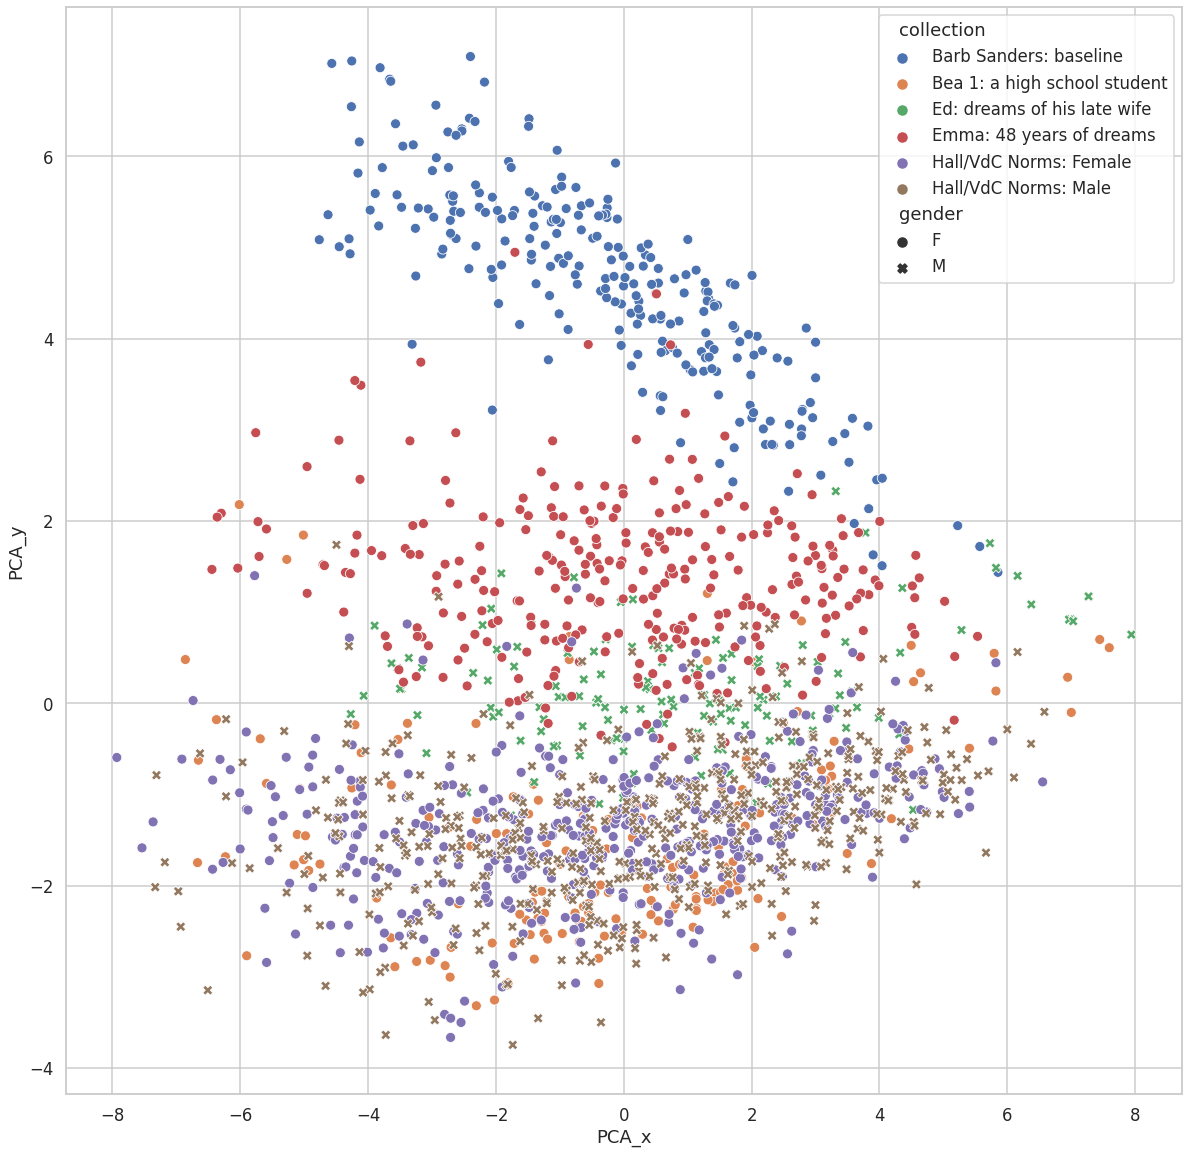

In [28]:
fig = plt.figure(figsize=(20,20))
g = sns.scatterplot(
    data=dream_records, 
    x="PCA_x", 
    y="PCA_y",
    style="gender", 
    hue="collection", 
    s=100
)
# sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

t-SNE data cluster, no K-Mean analys

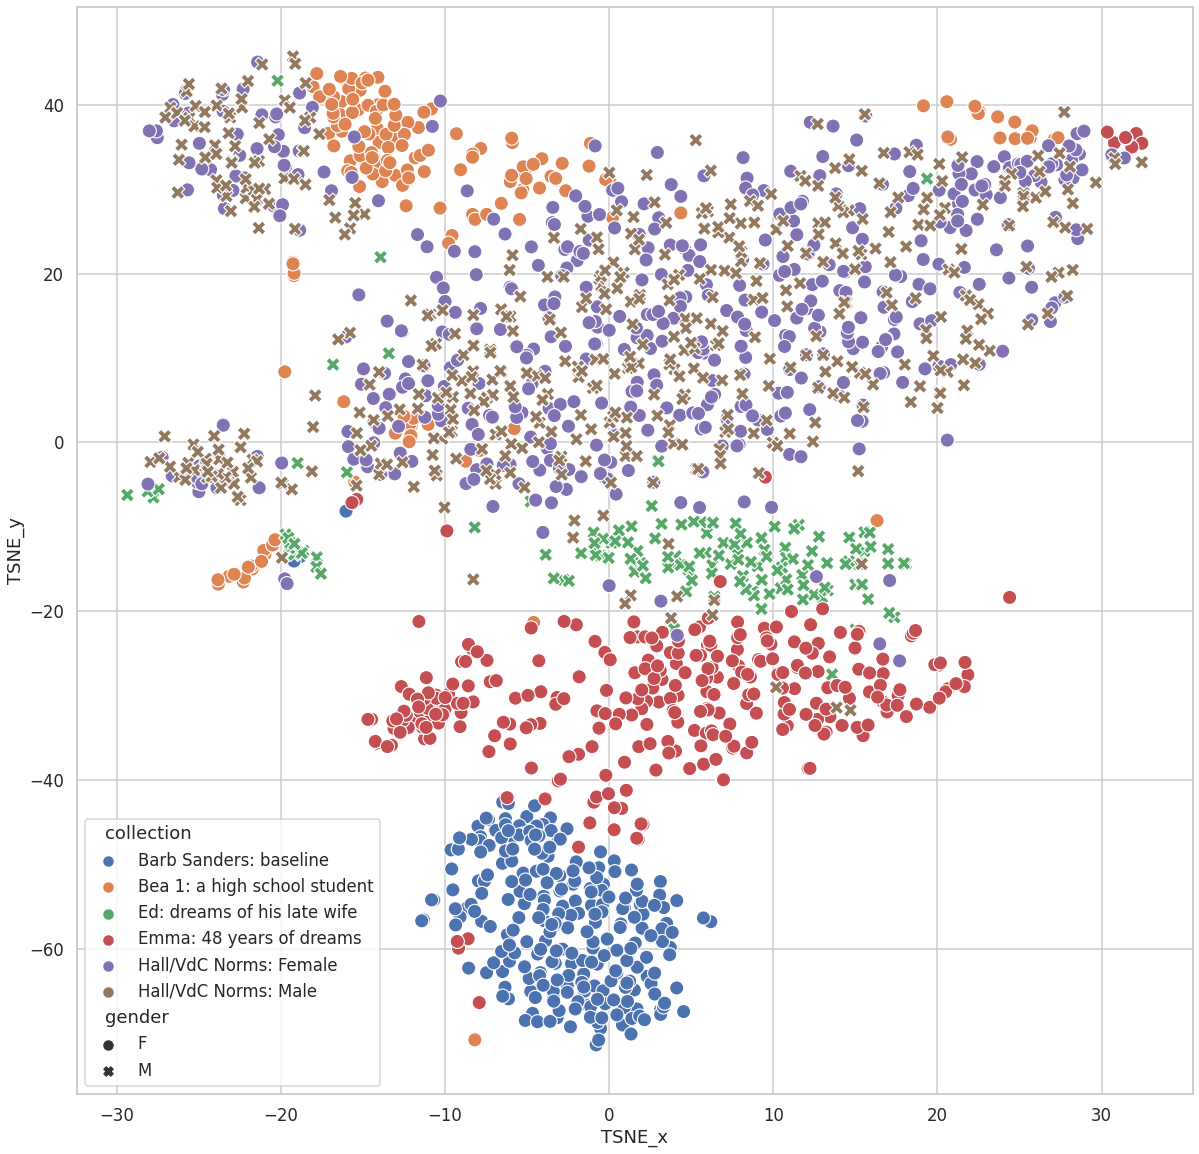

In [29]:
fig = plt.figure(figsize=(20,20))
g = sns.scatterplot(
    data=dream_records, 
    x="TSNE_x", 
    y="TSNE_y",
    style="gender",
    hue="collection", 
    s=200,
)
# plt.savefig('t-SNE_reduction.png', bbox_inches='tight', dpi=400)

#### KMean vs Data
Analysis of the comparison between the data-driven and K-Mean lerned clusters.
First, the encodings from BERT are analysed with the K-Mean, to extracted predicted patterns. Then, the clusters are compared to the ones in the data, in terms of gender and collections

In [30]:
# collect the clusters
X_km          = T_encoding
n_collections = len(set(dream_records["collection"]))
kmeans_cll    = KMeans(n_clusters=n_collections, random_state=seed).fit(X_km)
dream_records["KmC_Cll"] = kmeans_cll.labels_

n_genders     = 2
kmeans_gnd    = KMeans(n_clusters=n_genders, random_state=seed).fit(X_km)
dream_records["KmC_Gnd"] = kmeans_gnd.labels_

In [31]:
#Store the data
dream_records.to_csv(
    "Reports_with_Dreamer_and_General_Emotions_PCAxy_tSNExy_CllKmC_Gnd_KmC.csv",
    index=False,
)

Analysis of the distributions of each cluster with respect to collection and gender. Darker spots (cube/rectagle) indicats clusters of items idetified as belonging to one of the 6 K-Mean clusters. Ideally, one would see *n* dark cubes, where *n* is the number of collections. As seen, cluster 5 contains items from all the collections, ad similarly cluster 1. The only collection that seems to have an independent cluster is `Barb Sanders: baseline`. Anohter quite positive results is that cluster 2 seems to mainly refer to the two `Hall & Van de Castle Norms items`. The observation that the model is not discriminating between different genders can be found in the next image.

(<seaborn.axisgrid.FacetGrid at 0x7f65b1ac11c0>,
 <seaborn.axisgrid.FacetGrid at 0x7f65b1ac11c0>)

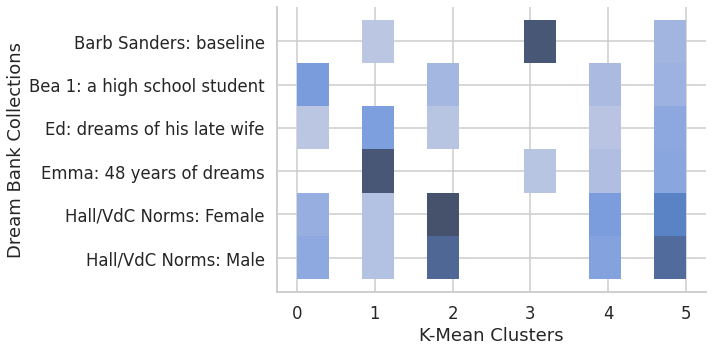

In [32]:
g = sns.displot(
    data=dream_records, 
    x="KmC_Cll", 
    y="collection",
    aspect=2,
)

g.set_xlabels("K-Mean Clusters"), g.set_ylabels("Dream Bank Collections")

(<seaborn.axisgrid.FacetGrid at 0x7f65b22a7f40>,
 <seaborn.axisgrid.FacetGrid at 0x7f65b22a7f40>)

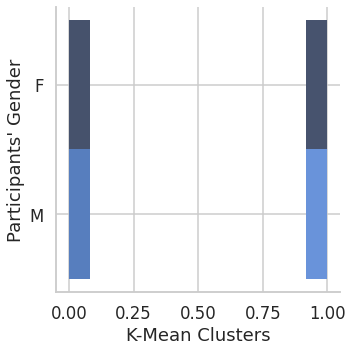

In [33]:
g = sns.displot(
    data=dream_records, 
    x="KmC_Gnd", 
    y="gender",
)

g.set_xlabels("K-Mean Clusters"), g.set_ylabels("Participants' Gender")

Searching for evidences on what has driven the cluster distinctions, considering Emotions, and number of words.

<AxesSubplot:xlabel='KmC_Cll', ylabel='# General Emotions'>

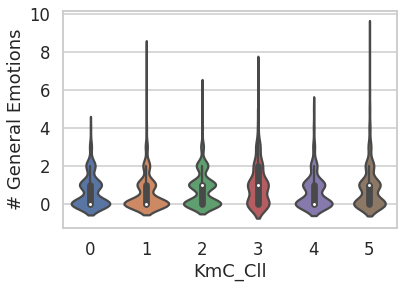

In [34]:
sns.violinplot(
    data=dream_records, 
    x="KmC_Cll", 
    y="# General Emotions",
    ci="se",
)

<AxesSubplot:xlabel='KmC_Gnd', ylabel='# General Emotions'>

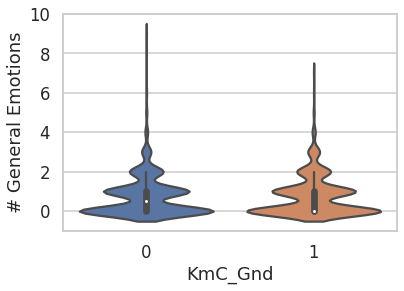

In [35]:
sns.violinplot(
    data=dream_records, 
    x="KmC_Gnd", 
    y="# General Emotions",
    ci="se",
)

Visualisation of the Collection and Gender clusters according to the K-MEan analysis and actual data. 

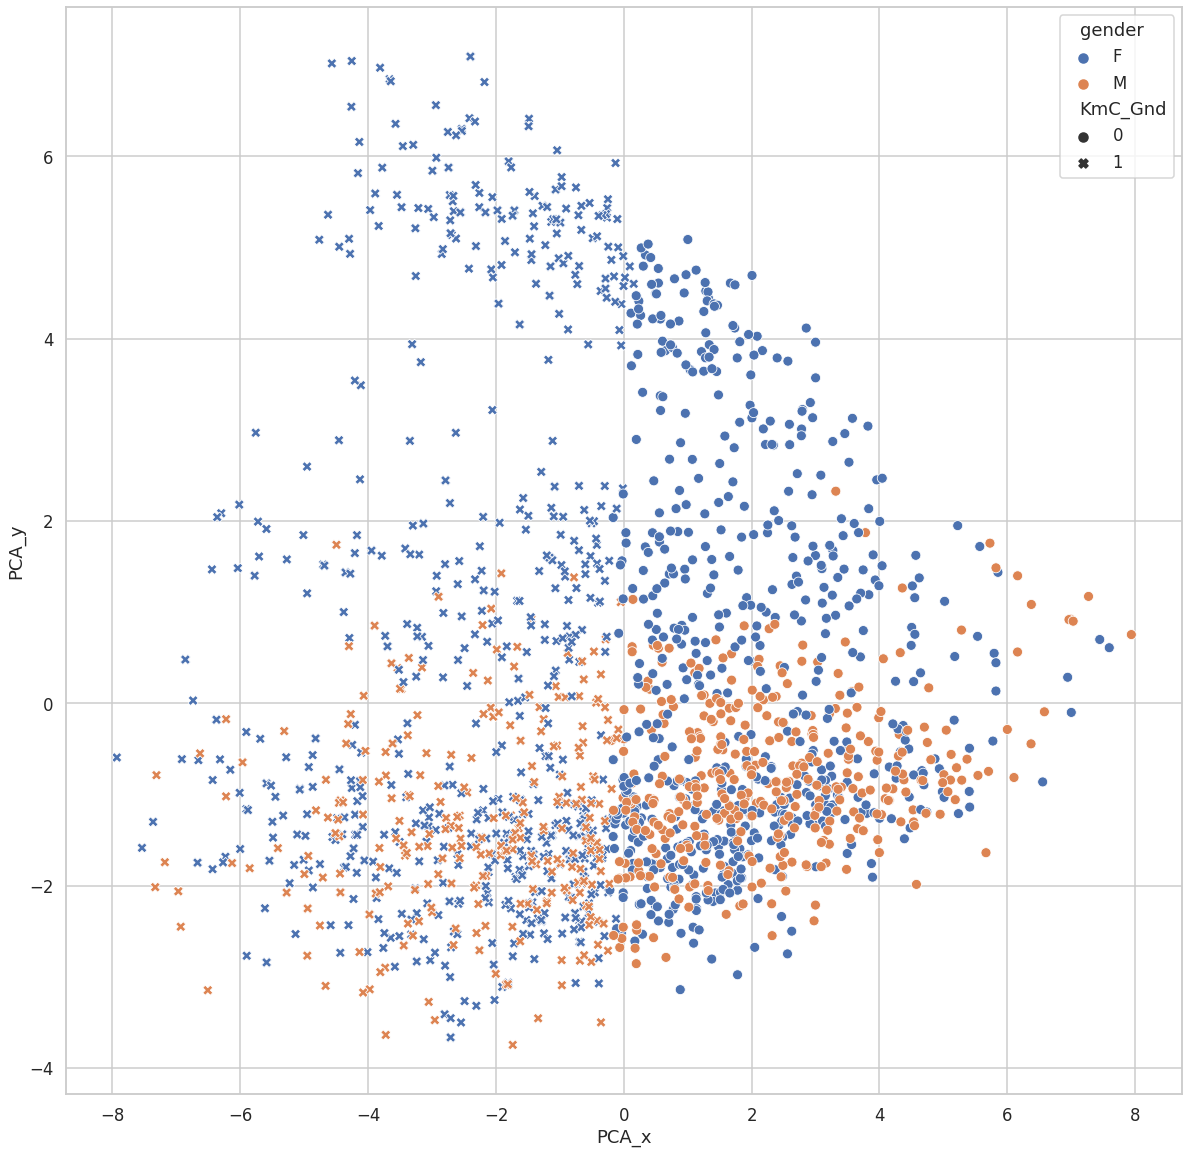

In [37]:
fig = plt.figure(figsize=(20,20))
g = sns.scatterplot(
    data=dream_records, 
    x="PCA_x", 
    y="PCA_y",
    style="KmC_Gnd", 
    hue="gender", 
    s=100,
)
# plt.savefig('PCA_reduction.png', bbox_inches='tight', dpi=400)

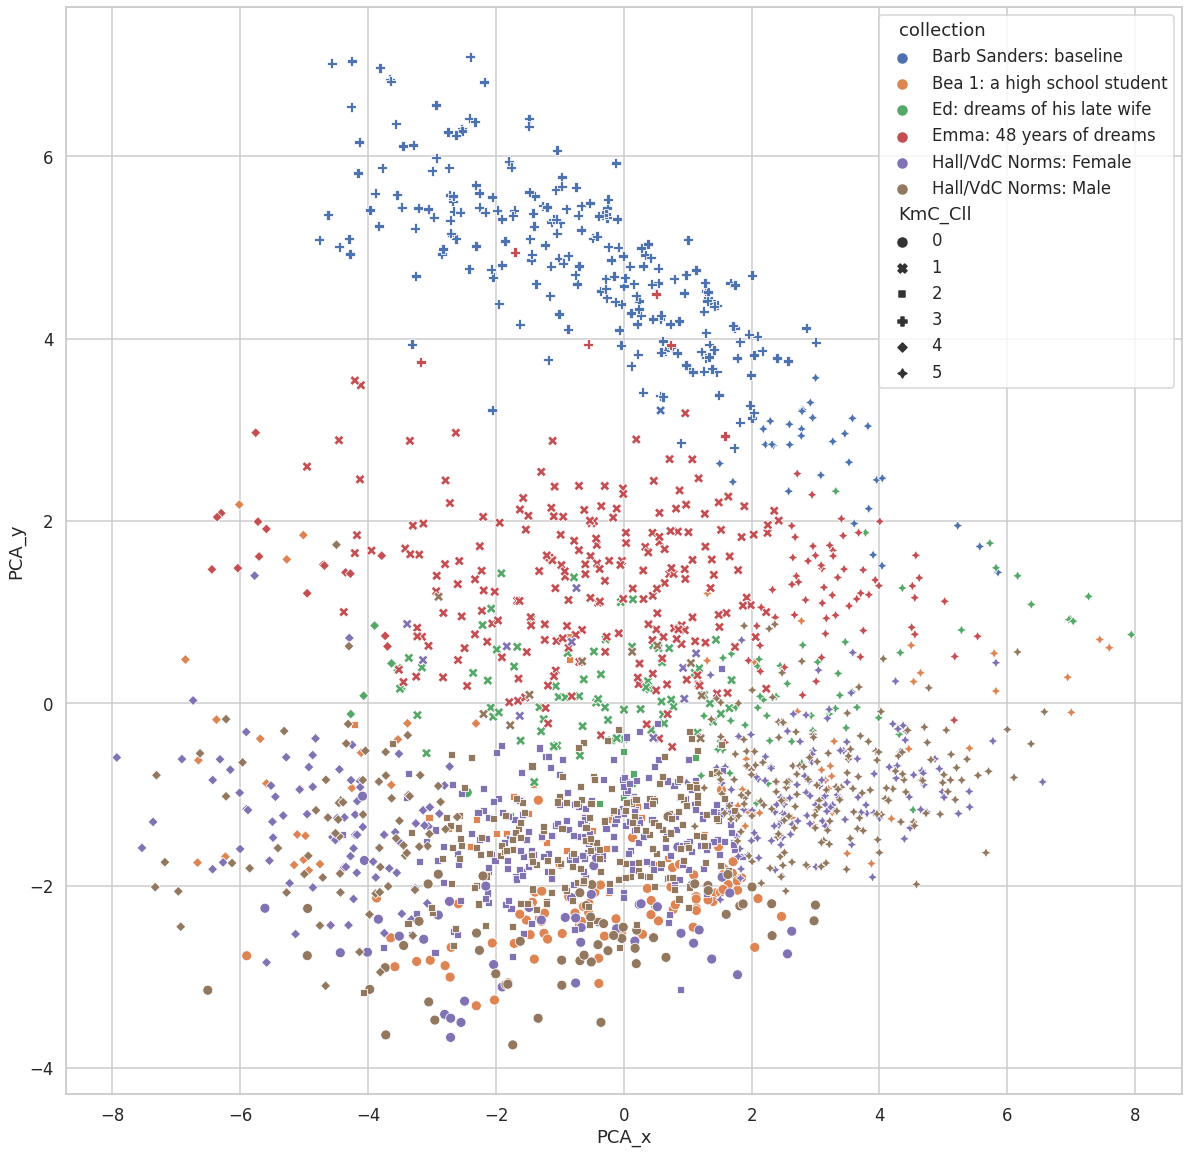

In [38]:
fig = plt.figure(figsize=(20,20))
g = sns.scatterplot(
    data=dream_records, 
    x="PCA_x", 
    y="PCA_y",
    style="KmC_Cll",
    hue="collection", 
    s=100,
)
# plt.savefig('PCA_reduction.png', bbox_inches='tight', dpi=400)

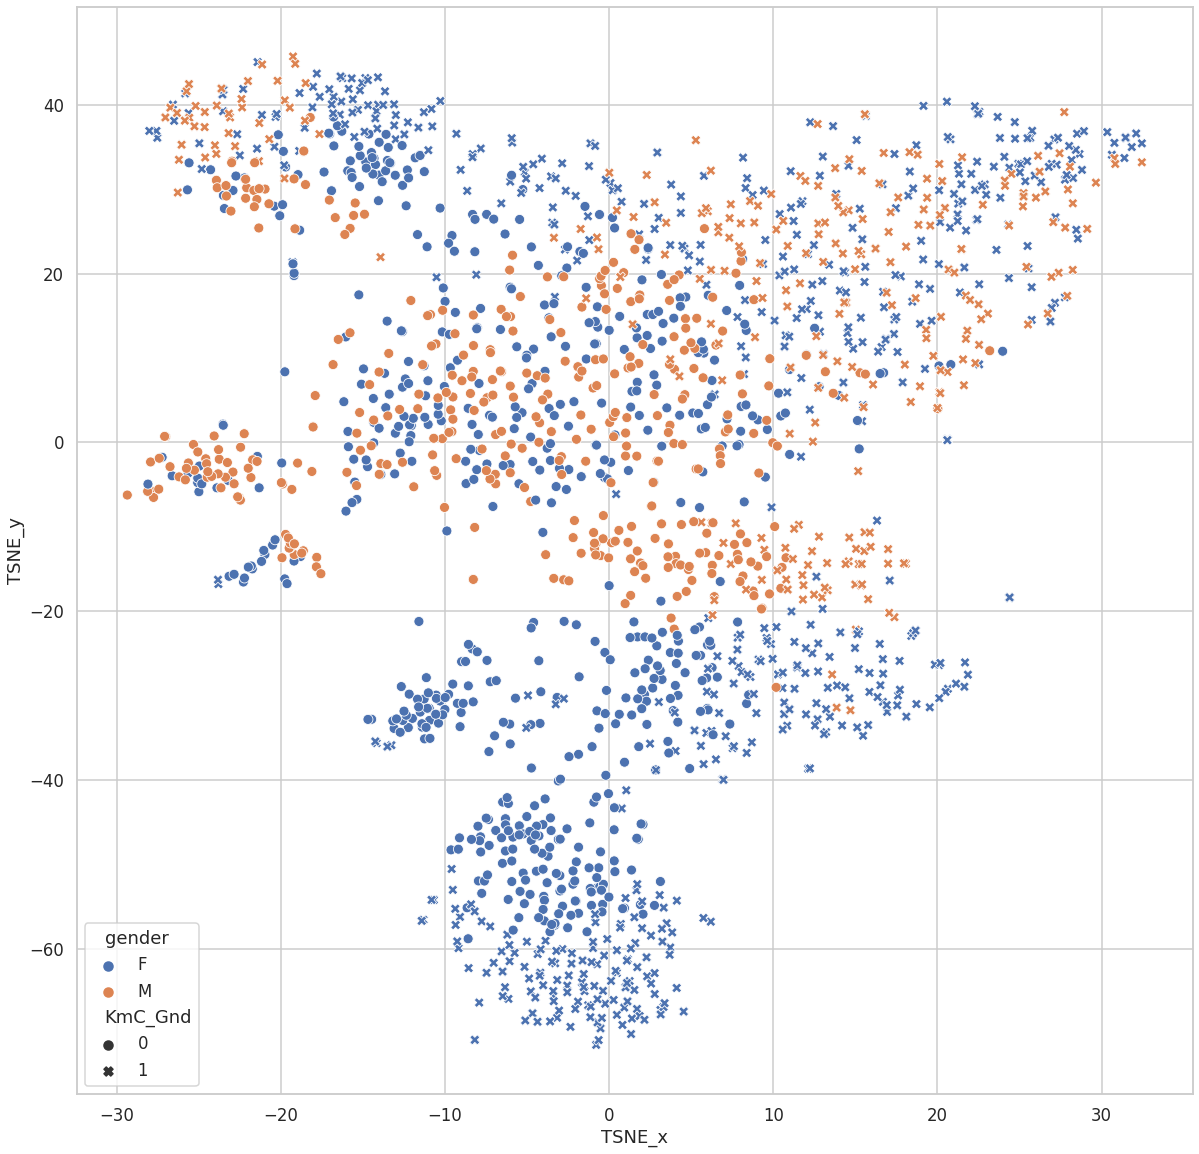

In [39]:
fig = plt.figure(figsize=(20,20))
g = sns.scatterplot(
    data=dream_records, 
    x="TSNE_x", 
    y="TSNE_y",
    style="KmC_Gnd", 
    hue="gender", 
    s=100,
)
# plt.savefig('PCA_reduction.png', bbox_inches='tight', dpi=400)

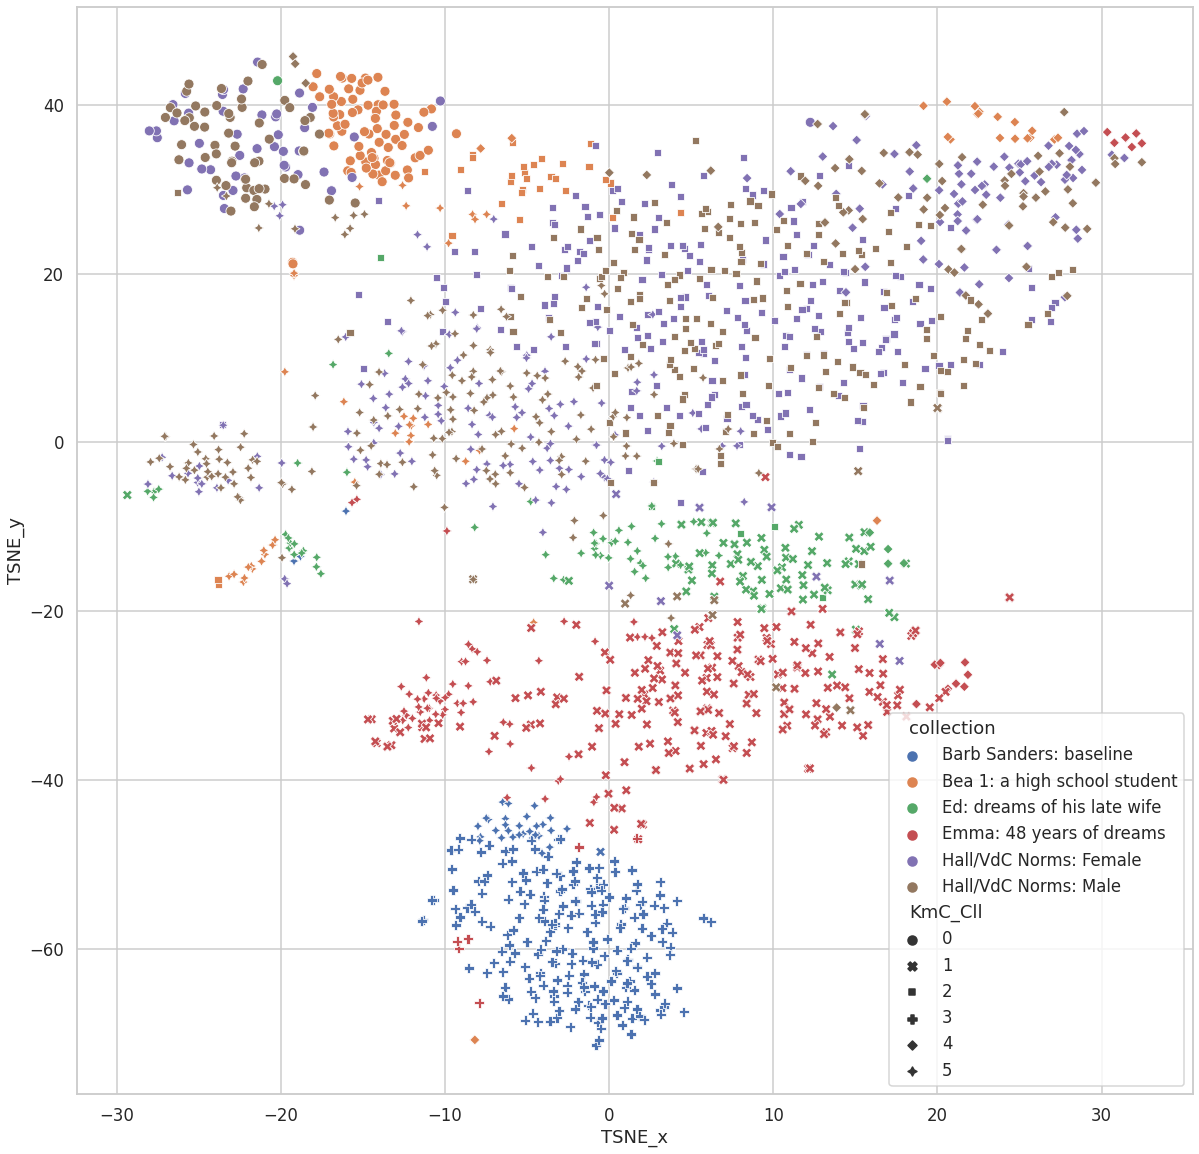

In [40]:
fig = plt.figure(figsize=(20,20))
g = sns.scatterplot(
    data=dream_records, 
    x="TSNE_x", 
    y="TSNE_y",
    style="KmC_Cll", 
    hue="collection", 
    s=100
)
# plt.savefig('PCA_reduction.png', bbox_inches='tight', dpi=400)